<a href="https://colab.research.google.com/github/avionerman/computational_and_statistical/blob/main/svm_part_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports, Data Loading & Data subsets

In [103]:
# import numpy as np
# from tensorflow.keras.datasets import cifar10
# from sklearn.model_selection import train_test_split, GridSearchCV
#!pip install cupy-cuda12x


In [104]:
#!pip install tensorflow
import numpy as np
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split, GridSearchCV

start_bold = "\u001b[1m"
end_bold = "\033[0m"

DATASET = "CIFAR10"
DATASET = DATASET.upper()

if DATASET == "CIFAR10":
    from tensorflow.keras.datasets import cifar10

    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    # Flatten labels to 1D
    y_train = y_train.flatten()
    y_test = y_test.flatten()

    class_names = [
        "airplane", "automobile", "bird", "cat", "deer",
        "dog", "frog", "horse", "ship", "truck"
    ]

elif DATASET == "SVHN":
    import os
    from scipy.io import loadmat
    import urllib.request

    def load_svhn_split(split, data_dir="/content/data"):
        """
        split: "train" or "test"
        returns X: (N, 32, 32, 3), y: (N,)
        """
        urls = {
            "train": "http://ufldl.stanford.edu/housenumbers/train_32x32.mat",
            "test":  "http://ufldl.stanford.edu/housenumbers/test_32x32.mat",
        }

        os.makedirs(data_dir, exist_ok=True)
        url = urls[split]
        filename = url.split("/")[-1]
        filepath = os.path.join(data_dir, filename)

        if not os.path.exists(filepath):
            print(f"Downloading SVHN {split} set...")
            urllib.request.urlretrieve(url, filepath)
            print("Download finished.")

        data = loadmat(filepath)
        # data["X"]: (32, 32, 3, N)
        # data["y"]: (N, 1), labels 1-10, with 10 meaning digit '0'
        X = data["X"]
        y = data["y"].flatten()

        # axes transform to (N, 32, 32, 3)
        X = np.transpose(X, (3, 0, 1, 2))

        # mapping label 10 -> 0 for digit '0'
        y[y == 10] = 0

        return X, y

    x_train, y_train = load_svhn_split("train")
    x_test, y_test = load_svhn_split("test")

    class_names = [str(i) for i in range(10)]

else:
    raise ValueError(f"Unknown DATASET: {DATASET}. Use 'CIFAR10' or 'SVHN'.")

# Optional: keep the same 5% train subset logic for BOTH datasets
# x_train, _, y_train, _ = train_test_split(
#     x_train, y_train, test_size=0.95, stratify=y_train, random_state=42
# )

# Preprocessing phase

## Flatten enablement

In [105]:
##### Flatten step #####

print(start_bold + "Flattening explanation:" + end_bold)
print("Flattening the data, is highly needed since both PCA and SVM cannot accept 3D data. \n"
"PCA calculates the covariance matrix among features. \n"
"That said, it needs an array of [samples x features], where each faeture is a column.\n")

x_train = x_train.reshape(len(x_train), -1)
x_test  = x_test.reshape(len(x_test), -1)
# x_train.shape, x_test.shape

Flattening explanation:
Flattening the data, is highly needed since both PCA and SVM cannot accept 3D data. 
PCA calculates the covariance matrix among features. 
That said, it needs an array of [samples x features], where each faeture is a column.



## Normalization enablement

In [106]:
##### Normalization step #####

print(start_bold + "Normalization explanation:" + end_bold)
print("I want to normalize my data mainly because I want to: \n"
"[1] to prevent my upcoming models from being dominated by large features.\n"
"[2] to feed a better scale for calculating distances for my models.\n"
"[3] and to help my PCA step with meaningful directions instead of large ones.\n")

x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0
# print(x_train.min(), x_train.max(), x_test.min(), x_test.max())

Normalization explanation:
I want to normalize my data mainly because I want to: 
[1] to prevent my upcoming models from being dominated by large features.
[2] to feed a better scale for calculating distances for my models.
[3] and to help my PCA step with meaningful directions instead of large ones.



## Standarization enablement

In [107]:
##### Standarization step #####

print(start_bold + "Standarization explanation:" + end_bold)
print("I want to standarize my data mainly because I want to: \n"
"[1] make my PCA work better since features with high deviation will not dominate.\n"
"[2] help my SVM to use all the features in a common scale.\n"
"*will use fit only for the training set, to prevent data leakage.\n"
"**fit learns info from the data, while transform applies the learned info to new data .\n"
"***mean should be 0, and std. dev should be 1.\n")

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print("The train mean (μ) is:", x_train_scaled.mean(),
      "and the std. dev (σ) is:", x_train_scaled.std())

Standarization explanation:
I want to standarize my data mainly because I want to: 
[1] make my PCA work better since features with high deviation will not dominate.
[2] help my SVM to use all the features in a common scale.
*will use fit only for the training set, to prevent data leakage.
**fit learns info from the data, while transform applies the learned info to new data .
***mean should be 0, and std. dev should be 1.

The train mean (μ) is: -1.4948844e-09 and the std. dev (σ) is: 0.99999964


## PCA enablement

In [108]:
##### PCA (Principal component analysis) step #####

print(start_bold + "PCA explanation:" + end_bold)
print("To be updated: \n"
"*full: accurate, slow, memory heavy. \n"
"**auto: data shape (n_samples, n_features) -- recommended. \n")

from sklearn.decomposition import PCA
import time

start_time = time.time()
pca = PCA(n_components=0.90, svd_solver="auto", random_state=42)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)
end_time = time.time()

print(f">>> The total PCA time was: {(end_time - start_time):.2f} seconds ({(end_time - start_time)/60:.2f} minutes)")
print(">>>",[float((pca.explained_variance_ratio_.sum())), (x_train_scaled.shape[1]), (x_train_pca.shape[1])] )

print("\n" + start_bold + "PCA results:" + end_bold)
print("Apparently, only 103 components are needed to explain almost 90% of the variance.\n"
"That looks good, because we has a huge dimensionality reduction from 3072 to 26, and at the same time"
"we didn't loose more than 10% of the total components.")

y_train_flat = y_train.ravel()
y_test_flat  = y_test.ravel()

print("\n>>> Running NaN checks after scaling and PCA...")

assert not np.isnan(x_train_scaled).any(), "NaNs found in x_train_scaled!"
assert not np.isnan(x_test_scaled).any(),  "NaNs found in x_test_scaled!"
assert not np.isnan(x_train_pca).any(),    "NaNs found in x_train_pca!"
assert not np.isnan(x_test_pca).any(),     "NaNs found in x_test_pca!"

assert not np.isnan(y_train_flat).any(),   "NaNs found in y_train_flat!"
assert not np.isnan(y_test_flat).any(),    "NaNs found in y_test_flat!"


PCA explanation:
To be updated: 
*full: accurate, slow, memory heavy. 
**auto: data shape (n_samples, n_features) -- recommended. 

>>> The total PCA time was: 18.10 seconds (0.30 minutes)
>>> [0.9006754159927368, 3072, 103]

PCA results:
Apparently, only 103 components are needed to explain almost 90% of the variance.
That looks good, because we has a huge dimensionality reduction from 3072 to 26, and at the same timewe didn't loose more than 10% of the total components.

>>> Running NaN checks after scaling and PCA...


# Test phase

The scope of this phase is only about checking if the pipeline works, if I get a logical accuracy and if the PCA works as expected on the dataset.

The optimization actions will come once the current step produces a logical baseline so we can start building on top of it in the following phase.

## Train an SVM with LinearSVC (once)

In [109]:
print(1)
# from sklearn.svm import LinearSVC
# from sklearn.metrics import accuracy_score
# import time
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     "C": [1]
# }

# grid = GridSearchCV(
#     LinearSVC(max_iter=5000),
#     param_grid=param_grid,
#     n_jobs=1,
#     verbose=3
# )

# start_time = time.time()
# grid.fit(x_train_pca, y_train_flat)
# train_time = time.time() - start_time

# print(f">>> The total LinearSVC time was: {train_time:.2f} seconds")

# y_train_pred_linearsvc = grid.predict(x_train_pca)
# y_test_pred_linearsvc  = grid.predict(x_test_pca)

# train_acc_w_linearsvc = accuracy_score(y_train_flat, y_train_pred_linearsvc)
# test_acc_w_linearsvc  = accuracy_score(y_test_flat, y_test_pred_linearsvc)

# print(f">>> The train accuracy was {train_acc_w_linearsvc:.4f} and the test accuracy was {test_acc_w_linearsvc:.4f}")

# print("\n" + start_bold + "LinearSVC results:" + end_bold)
# print("The train accuracy was close to 40%, same as the test accuracy.\n"
# "That looks good, firstly because we don't have to worry about overfitting, and secondly the pipeline is working as expected.\n")

1


## Train an SVM with SVC(kernel=linear) (once)

In [110]:
print(1)
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score
# import time

# model = SVC(kernel="linear", C=1.0, verbose=True)

# start_time = time.time()
# model.fit(x_train_pca, y_train_flat)
# train_time = time.time() - start_time

# print(f">>> The total SVC (linear) time was: {train_time:.2f} seconds")

# y_train_pred = model.predict(x_train_pca)
# y_test_pred  = model.predict(x_test_pca)

# train_acc = accuracy_score(y_train_flat, y_train_pred)
# test_acc  = accuracy_score(y_test_flat, y_test_pred)

# print(f">>> The train accuracy was {train_acc:.2f} and the test accuracy was {test_acc:.2f}")

1


# Model Selection - LinearSVC

In [111]:
import time
import pandas as pd
import cupy as cp

from cuml.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# transform data to GPU
x_train_gpu = cp.asarray(x_train_pca)
x_test_gpu  = cp.asarray(x_test_pca)
y_train_gpu = cp.asarray(y_train_flat)

param_grid = {
    "C": [0.1, 1, 5, 10]
}

grid = GridSearchCV(
    estimator=LinearSVC(),
    param_grid=param_grid,
    cv=5,
    verbose=2,
    n_jobs=1
)

start_time = time.time()
grid.fit(x_train_gpu, y_train_flat)
grid_time = time.time() - start_time

print(f"\n >>> LinearSVC(GPU) total time: {grid_time:.2f} seconds")

best_model = grid.best_estimator_
best_params = grid.best_params_

print("\n >>> LinearSVC(GPU) Summary")
print("Best mean CV accuracy:", grid.best_score_)
print("Best params:", best_params)

# make the predictions on GPU
y_train_pred = cp.asnumpy(best_model.predict(x_train_gpu))
y_test_pred  = cp.asnumpy(best_model.predict(x_test_gpu))

train_acc = accuracy_score(y_train_flat, y_train_pred)
test_acc  = accuracy_score(y_test_flat,  y_test_pred)

print("\nFinal Evaluation:")
print("Train acc:", train_acc)
print("Test acc:", test_acc)

results = pd.DataFrame(grid.cv_results_)
cv_table = results[["param_C", "mean_test_score", "std_test_score", "rank_test_score"]]

print("\n >>> Cross-Validation outcome table")
print(cv_table.sort_values("rank_test_score"))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..............................................C=0.1; total time=   0.3s
[CV] END ..............................................C=0.1; total time=   0.3s
[CV] END ..............................................C=0.1; total time=   0.3s
[CV] END ..............................................C=0.1; total time=   0.3s
[CV] END ..............................................C=0.1; total time=   0.3s
[CV] END ................................................C=1; total time=   0.3s
[CV] END ................................................C=1; total time=   0.3s
[CV] END ................................................C=1; total time=   0.3s
[CV] END ................................................C=1; total time=   0.3s
[CV] END ................................................C=1; total time=   0.3s
[CV] END ................................................C=5; total time=   0.3s
[CV] END ........................................

# Model Selection - SVC(kernel=rbf)

In [112]:
import time
import pandas as pd
import cupy as cp

from cuml.svm import SVC
from cuml.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# transform data to GPU
x_train_gpu = cp.asarray(x_train_pca)
x_test_gpu  = cp.asarray(x_test_pca)
y_train_gpu = cp.asarray(y_train_flat)

param_grid_rbf = {
    "C": [0.1, 1, 5, 10],
    "gamma": ["scale"]
}

rbf_grid = GridSearchCV(
    estimator=SVC(kernel="rbf"),
    param_grid=param_grid_rbf,
    cv=5,
    verbose=2,
    n_jobs=1
)

start_time = time.time()
rbf_grid.fit(x_train_gpu, y_train_flat)
rbf_time = time.time() - start_time

print(f"\n >>> SVM(rbf, GPU) with GridSearchCV total execution time: {rbf_time:.2f} seconds")

best_rbf_score  = float(rbf_grid.best_score_)
best_rbf_params = rbf_grid.best_params_
best_rbf_model  = rbf_grid.best_estimator_

print("\n >>> SVM(rbf, GPU) Execution Summary")
print("----------------------------")
print(f"Best mean CV accuracy: {best_rbf_score:.4f}")
print(f"Best hyperparameters: {best_rbf_params}")
print(f"Best model: {best_rbf_model}")

# --- make the predictions on GPU, and transform back to CPU for metrics (acc)
y_train_pred_gpu = best_rbf_model.predict(x_train_gpu)
y_test_pred_gpu  = best_rbf_model.predict(x_test_gpu)

y_train_pred_rbf = cp.asnumpy(y_train_pred_gpu)
y_test_pred_rbf  = cp.asnumpy(y_test_pred_gpu)

train_acc_rbf = accuracy_score(y_train_flat, y_train_pred_rbf)
test_acc_rbf  = accuracy_score(y_test_flat,  y_test_pred_rbf)

print("\n >>> Final Evaluation of the best SVM(rbf, GPU)")
print(f"Train accuracy: {train_acc_rbf:.4f}")
print(f"Test accuracy:  {test_acc_rbf:.4f}")

rbf_results = pd.DataFrame(rbf_grid.cv_results_)

rbf_cv_table = rbf_results[
    ["param_C", "param_gamma", "mean_test_score", "std_test_score", "rank_test_score"]
]
print("\n >>> RBF Cross-Validation outcome table")
print(rbf_cv_table.sort_values("rank_test_score"))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .................................C=0.1, gamma=scale; total time=   1.9s
[CV] END .................................C=0.1, gamma=scale; total time=   1.9s
[CV] END .................................C=0.1, gamma=scale; total time=   2.0s
[CV] END .................................C=0.1, gamma=scale; total time=   2.0s
[CV] END .................................C=0.1, gamma=scale; total time=   1.9s
[CV] END ...................................C=1, gamma=scale; total time=   2.6s
[CV] END ...................................C=1, gamma=scale; total time=   2.5s
[CV] END ...................................C=1, gamma=scale; total time=   2.6s
[CV] END ...................................C=1, gamma=scale; total time=   2.6s
[CV] END ...................................C=1, gamma=scale; total time=   2.5s
[CV] END ...................................C=5, gamma=scale; total time=   6.0s
[CV] END ...................................C=5, 

# Model Selection - SVC(kernel=linear)

In [113]:
print(1)
# import time
# import pandas as pd
# import cupy as cp

# from cuml.svm import SVC
# from cuml.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score


# x_train_contig = np.ascontiguousarray(x_train_pca)
# x_test_contig  = np.ascontiguousarray(x_test_pca)

# x_train_gpu = cp.asarray(x_train_contig)
# x_test_gpu  = cp.asarray(x_test_contig)
# y_train_gpu = cp.asarray(y_train_flat)


# param_grid_linear = {
#     "C": [0.1, 1, 10,]
# }


# print("\n>>> Starting SVM(kernel='linear') GridSearchCV on GPU...")

# # clear GPU working memory BEFORE GridSearchCV — avoids cuML crash
# cp.cuda.Stream.null.synchronize()
# cp.get_default_memory_pool().free_all_blocks()

# linear_grid = GridSearchCV(
#     estimator=SVC(kernel="linear", tol=1e-3),
#     param_grid=param_grid_linear,
#     cv=5,
#     verbose=2,
#     n_jobs=1
# )

# start_time = time.time()
# linear_grid.fit(x_train_gpu, y_train_flat)
# linear_time = time.time() - start_time

# print(f"\n >>> SVM(linear, GPU) GridSearchCV total time: {linear_time:.2f} seconds")


# best_linear_score  = float(linear_grid.best_score_)
# best_linear_params = linear_grid.best_params_
# best_linear_model  = linear_grid.best_estimator_

# print("\n >>> SVM(linear, GPU) Execution Summary")
# print("----------------------------------------")
# print(f"Best mean CV accuracy: {best_linear_score:.4f}")
# print(f"Best hyperparameters: {best_linear_params}")
# print(f"Best model: {best_linear_model}")


# y_train_pred_gpu = best_linear_model.predict(x_train_gpu)
# y_test_pred_gpu  = best_linear_model.predict(x_test_gpu)

# y_train_pred_linear = cp.asnumpy(y_train_pred_gpu)
# y_test_pred_linear  = cp.asnumpy(y_test_pred_gpu)

# train_acc_linear = accuracy_score(y_train_flat, y_train_pred_linear)
# test_acc_linear  = accuracy_score(y_test_flat,  y_test_pred_linear)

# print("\n >>> Final Evaluation of the best SVM(linear, GPU)")
# print(f"Train accuracy: {train_acc_linear:.4f}")
# print(f"Test accuracy:  {test_acc_linear:.4f}")


# linear_results = pd.DataFrame(linear_grid.cv_results_)

# linear_cv_table = linear_results[
#     ["param_C", "mean_test_score", "std_test_score", "rank_test_score"]
# ]

# print("\n >>> Linear SVM Cross-Validation outcome table")
# print(linear_cv_table.sort_values("rank_test_score"))


1


# Model Selection - SVC(kernel=poly)



In [114]:
param_grid_poly = {
    "C": [0.1, 1, 5, 10],
    "degree": [3, 4]
}

grid_poly = GridSearchCV(
    estimator=SVC(kernel="poly", gamma="scale", coef0=0),
    param_grid=param_grid_poly,
    cv=5,
    verbose=2,
    n_jobs=1
)

start = time.time()
grid_poly.fit(x_train_pca, y_train_flat)
time_poly = time.time() - start

print(f"\n>>> SVC(poly) GridSearchCV time: {time_poly:.2f} sec")
print("Best params:", grid_poly.best_params_)
print("Best CV score:", grid_poly.best_score_)

best_poly = grid_poly.best_estimator_

y_train_pred_poly = best_poly.predict(x_train_pca)
y_test_pred_poly  = best_poly.predict(x_test_pca)

train_acc_poly = accuracy_score(y_train_flat, y_train_pred_poly)
test_acc_poly  = accuracy_score(y_test_flat,  y_test_pred_poly)

print("\n>>> Final SVC (poly)")
print(f"Train accuracy: {train_acc_poly:.4f}")
print(f"Test accuracy:  {test_acc_poly:.4f}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ....................................C=0.1, degree=3; total time=   2.4s
[CV] END ....................................C=0.1, degree=3; total time=   2.4s
[CV] END ....................................C=0.1, degree=3; total time=   2.4s
[CV] END ....................................C=0.1, degree=3; total time=   2.4s
[CV] END ....................................C=0.1, degree=3; total time=   2.4s
[CV] END ....................................C=0.1, degree=4; total time=   2.7s
[CV] END ....................................C=0.1, degree=4; total time=   2.6s
[CV] END ....................................C=0.1, degree=4; total time=   2.7s
[CV] END ....................................C=0.1, degree=4; total time=   2.7s
[CV] END ....................................C=0.1, degree=4; total time=   2.7s
[CV] END ......................................C=1, degree=3; total time=   4.1s
[CV] END ......................................C=

# kNN & NCC models

In [115]:
import time
import numpy as np
import cupy as cp

from cuml.neighbors import KNeighborsClassifier as cuKNN
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from scipy import sparse

# transform data for GPU
if sparse.issparse(x_train_pca):
    x_train_dense = x_train_pca.toarray()
    x_test_dense  = x_test_pca.toarray()
else:
    x_train_dense = x_train_pca
    x_test_dense  = x_test_pca

x_train_gpu = cp.asarray(x_train_dense)
x_test_gpu  = cp.asarray(x_test_dense)
y_train_gpu = cp.asarray(y_train_flat)

k_values = list(range(1, 20))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_k = None
best_cv_score = -1.0
k_scores = []

start = time.time()

print("\n>>> Starting KNN (GPU) cross-validation over k...\n")
for k in k_values:
    fold_scores = []

    for train_idx, val_idx in cv.split(x_train_pca, y_train_flat):


        x_tr_gpu = x_train_gpu[train_idx]
        y_tr_gpu = y_train_gpu[train_idx]
        x_val_gpu = x_train_gpu[val_idx]
        y_val = y_train_flat[val_idx]

        knn_gpu = cuKNN(n_neighbors=k)
        knn_gpu.fit(x_tr_gpu, y_tr_gpu)

        # predict with GPU and then transform to CPU
        y_val_pred_gpu = knn_gpu.predict(x_val_gpu)
        y_val_pred = cp.asnumpy(y_val_pred_gpu)

        fold_scores.append(accuracy_score(y_val, y_val_pred))

    mean_score = float(np.mean(fold_scores))
    k_scores.append((k, mean_score))
    print(f"k={k:3d} | mean CV accuracy={mean_score:.4f}")

    if mean_score > best_cv_score:
        best_cv_score = mean_score
        best_k = k

knn_cv_time = time.time() - start

print(f"\n>>> Best k from CV: {best_k} with mean accuracy {best_cv_score:.4f}")
print(f">>> KNN CV search time (GPU): {knn_cv_time:.2f} sec\n")

# train the final kNN using the best k on full training set (with GPU)
best_knn_gpu = cuKNN(n_neighbors=best_k)

start = time.time()
best_knn_gpu.fit(x_train_gpu, y_train_gpu)
knn_train_time = time.time() - start

start = time.time()
y_test_pred_gpu = best_knn_gpu.predict(x_test_gpu)
knn_test_time = time.time() - start

# bring the predictions for accuracy and transform back to CPU
y_test_pred = cp.asnumpy(y_test_pred_gpu)
y_train_pred = cp.asnumpy(best_knn_gpu.predict(x_train_gpu))

knn_train_acc = accuracy_score(y_train_flat, y_train_pred)
knn_test_acc  = accuracy_score(y_test_flat,  y_test_pred)

print("\n KNN (k-Nearest Neighbors, GPU)\n")
print(f"Best k from CV: ", best_k)
print(f"CV search time (GPU): {knn_cv_time:.2f} sec")
print(f"Train time (best k only): {knn_train_time:.2f} sec")
print(f"Test time: {knn_test_time:.2f} sec\n")
print(f"Train accuracy (best k): {knn_train_acc:.4f}")
print(f"Test accuracy  (best k): {knn_test_acc:.4f}\n")



ncc = NearestCentroid()

start = time.time()
ncc.fit(x_train_pca, y_train_flat)
ncc_train_time = time.time() - start

start = time.time()
y_test_pred_ncc = ncc.predict(x_test_pca)
ncc_test_time = time.time() - start

ncc_train_acc = ncc.score(x_train_pca, y_train_flat)
ncc_test_acc  = ncc.score(x_test_pca,  y_test_flat)

print("\n NCC (Nearest Class Centroid)\n")
print(f"Train time: {ncc_train_time:.4f} sec")
print(f"Test time: {ncc_test_time:.4f} sec\n")
print(f"Train accuracy: {ncc_train_acc:.4f}")
print(f"Test accuracy: {ncc_test_acc:.4f}\n")



>>> Starting KNN (GPU) cross-validation over k...

k=  1 | mean CV accuracy=0.3757
k=  2 | mean CV accuracy=0.3367
k=  3 | mean CV accuracy=0.3620
k=  4 | mean CV accuracy=0.3691
k=  5 | mean CV accuracy=0.3739
k=  6 | mean CV accuracy=0.3718
k=  7 | mean CV accuracy=0.3742
k=  8 | mean CV accuracy=0.3760
k=  9 | mean CV accuracy=0.3752
k= 10 | mean CV accuracy=0.3751
k= 11 | mean CV accuracy=0.3741
k= 12 | mean CV accuracy=0.3740
k= 13 | mean CV accuracy=0.3726
k= 14 | mean CV accuracy=0.3715
k= 15 | mean CV accuracy=0.3707
k= 16 | mean CV accuracy=0.3696
k= 17 | mean CV accuracy=0.3687
k= 18 | mean CV accuracy=0.3696
k= 19 | mean CV accuracy=0.3699

>>> Best k from CV: 8 with mean accuracy 0.3760
>>> KNN CV search time (GPU): 2.01 sec


 KNN (k-Nearest Neighbors, GPU)

Best k from CV:  8
CV search time (GPU): 2.01 sec
Train time (best k only): 0.00 sec
Test time: 0.02 sec

Train accuracy (best k): 0.5071
Test accuracy  (best k): 0.3814


 NCC (Nearest Class Centroid)

Train time: 0.

# Summary results

In [118]:
import pandas as pd

summary = pd.DataFrame([
    ["LinearSVC",  train_acc, test_acc, grid_time],
    ["RBF SVM",    train_acc_rbf,    test_acc_rbf,    rbf_time],
    #["Linear SVM", train_acc_linear, test_acc_linear, linear_time],
    ["Poly SVM",   train_acc_poly,   test_acc_poly,   time_poly],
    ["kNN",  knn_train_acc,    knn_test_acc,    knn_train_time],
    ["NCC",        ncc_train_acc,    ncc_test_acc,    ncc_train_time],
], columns=["Model", "Train Accuracy", "Test Accuracy", "Train Time (s)"])

print("\n Summary results")
print(summary)



 Summary results
       Model  Train Accuracy  Test Accuracy  Train Time (s)
0  LinearSVC         0.39804         0.3962        6.202266
1    RBF SVM         0.86664         0.5665       99.876186
2   Poly SVM         0.90078         0.4837      278.547397
3        kNN         0.50710         0.3814        0.001906
4        NCC         0.27120         0.2807        0.071383


# Cateforization examples (visualization)

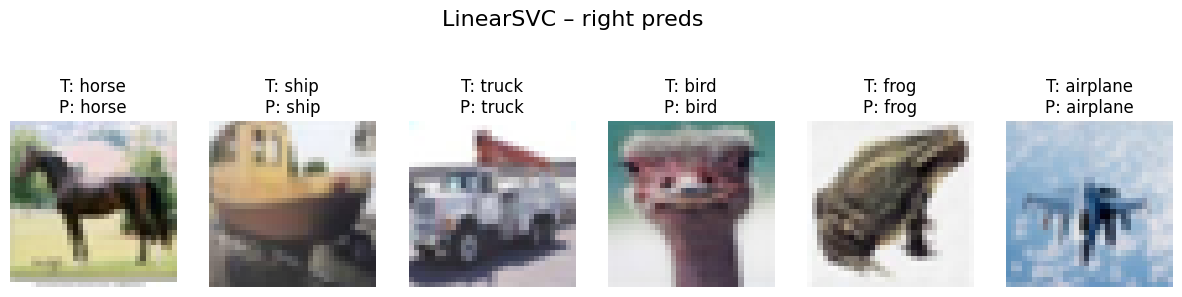

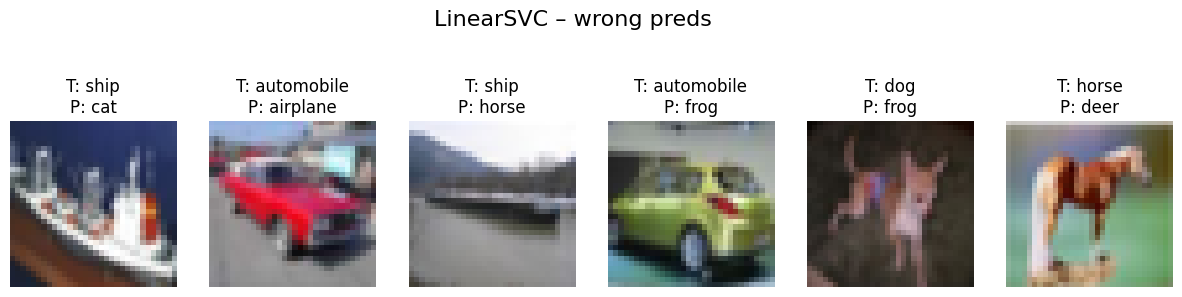

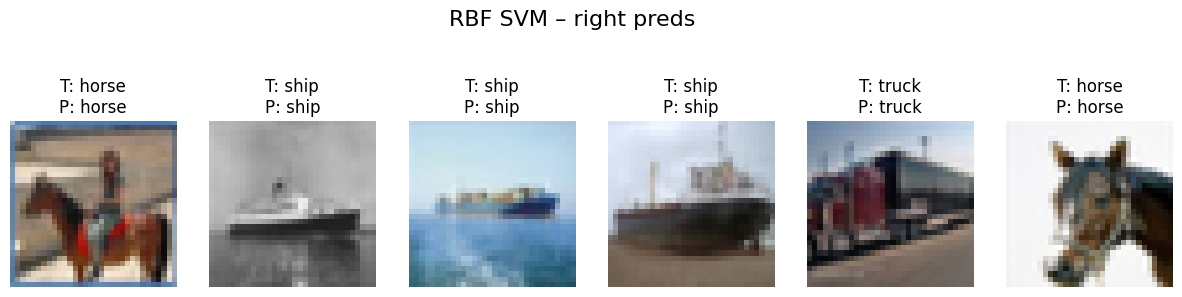

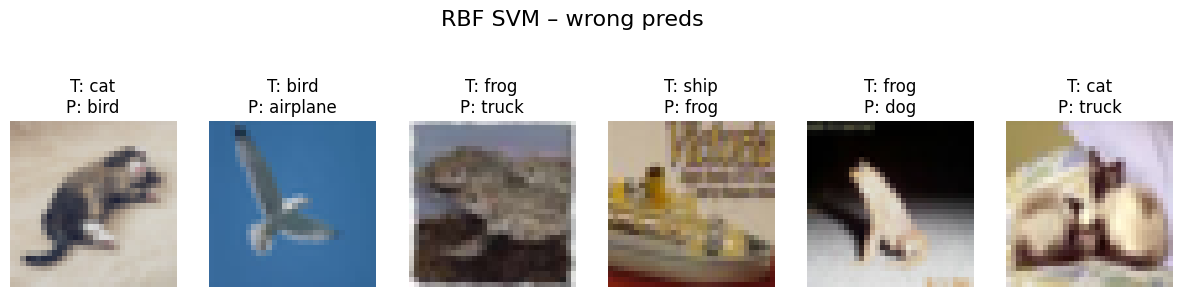

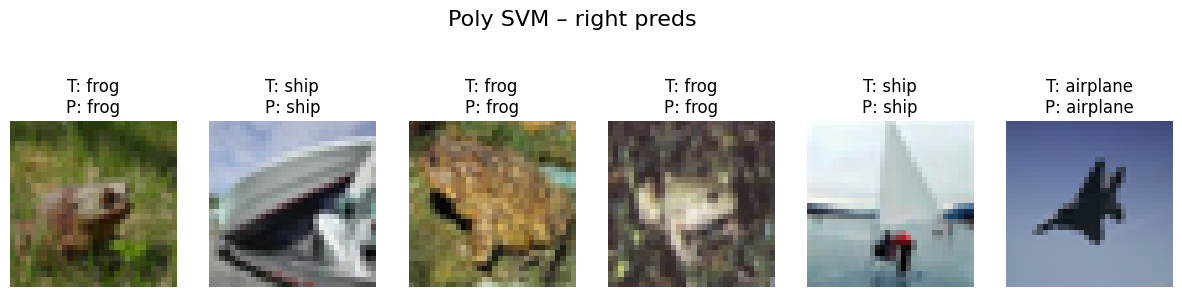

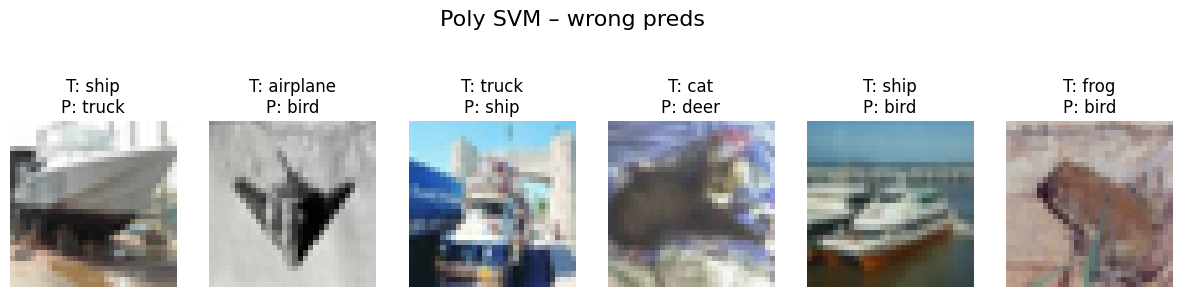

In [119]:
import numpy as np
import matplotlib.pyplot as plt

def show_examples(images, y_true, y_pred, class_names, correct=True, n=6, title=""):
    """
    images: original x_test (not PCA)
    y_true: real labels (1D)
    y_pred: predicted labels (1D)
    correct=True  -> show correct predictions
    correct=False -> show incorrect predictions
    """

    # --- Safety checks & alignment ---
    len_img  = len(images)
    len_true = len(y_true)
    len_pred = len(y_pred)

    min_len = min(len_img, len_true, len_pred)
    if not (len_img == len_true == len_pred):
        print(
            f"[WARNING] Length mismatch in show_examples() "
            f"(images={len_img}, y_true={len_true}, y_pred={len_pred}). "
            f"Using first {min_len} samples for all."
        )

        images = images[:min_len]
        y_true = y_true[:min_len]
        y_pred = y_pred[:min_len]

    # --- Select indices of correct / incorrect predictions ---
    if correct:
        idx = np.where(y_true == y_pred)[0]
    else:
        idx = np.where(y_true != y_pred)[0]

    if len(idx) == 0:
        print("No examples found for this case.")
        return

    # --- Randomly choose up to n examples to display ---
    n_to_show = min(n, len(idx))
    chosen = np.random.choice(idx, size=n_to_show, replace=False)

    plt.figure(figsize=(15, 4))
    plt.suptitle(title, fontsize=16)

    for i, j in enumerate(chosen):
        plt.subplot(1, n_to_show, i + 1)
        # assume (32, 32, 3); if already in that shape, reshape does nothing harmful
        plt.imshow(images[j].reshape(32, 32, 3))
        plt.axis("off")
        plt.title(f"T: {class_names[y_true[j]]}\nP: {class_names[y_pred[j]]}")

    plt.show()


# ---- Calls stay the same ----

show_examples(
    x_test,
    y_test_flat,
    y_test_pred,
    class_names,
    correct=True,
    n=6,
    title="LinearSVC – right preds"
)

show_examples(
    x_test,
    y_test_flat,
    y_test_pred,
    class_names,
    correct=False,
    n=6,
    title="LinearSVC – wrong preds"
)


show_examples(
    x_test,
    y_test_flat,
    y_test_pred_rbf,
    class_names,
    correct=True,
    n=6,
    title="RBF SVM – right preds"
)

show_examples(
    x_test,
    y_test_flat,
    y_test_pred_rbf,
    class_names,
    correct=False,
    n=6,
    title="RBF SVM – wrong preds"
)


# show_examples(
#     x_test,
#     y_test_flat,
#     y_test_pred_linear,
#     class_names,
#     correct=True,
#     n=6,
#     title="Linear SVM – Correct Predictions"
# )

# show_examples(
#     x_test,
#     y_test_flat,
#     y_test_pred_linear,
#     class_names,
#     correct=False,
#     n=6,
#     title="Linear SVM – Incorrect Predictions"
# )


show_examples(
    x_test,
    y_test_flat,
    y_test_pred_poly,
    class_names,
    correct=True,
    n=6,
    title="Poly SVM – right preds"
)

show_examples(
    x_test,
    y_test_flat,
    y_test_pred_poly,
    class_names,
    correct=False,
    n=6,
    title="Poly SVM – wrong preds"
)
